In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 13.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path as osp
from konlpy.tag import Okt
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 세팅

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/colab/LSTM tuning/preprocessed.csv')
train

,Unnamed: 0,Q,emotion_label,preproc,prep
0,0,일은 왜 해도 해도 끝이 없을까? 화가 난다.,1,일은 왜 해도 해도 끝이 없을까 화가 난다,"['끝', '화가', '나다']"
1,1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,1,이번 달에 또 급여가 깎였어 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나,"['달', '급여', '깎다', '물가', '월급', '자꾸', '깎다', '너무'..."
2,2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,1,회사에 신입이 들어왔는데 말투가 거슬려 그런 애를 매일 봐야 한다고 생각하니까 스트...,"['회사', '신입', '들어오다', '말투', '거슬리다', '그렇다', '애',..."
3,3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,1,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜 일도 많은 데 정말 분하고 섭섭해,"['직장', '막내', '이유', '온갖', '심부름', '일도', '많다', '정..."
4,4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,1,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나,"['입사', '신입사원', '나르다', '무시', '너무', '화가']"
...,...,...,...,...,...
56989,56989,병원에서 친하게 지내던 환자가 암으로 죽어서 너무 슬퍼.,4,병원에서 친하게 지내던 환자가 암으로 죽어서 너무 슬퍼,"['병원', '친하다', '지내다', '환자', '암', '죽다', '너무', '슬..."
56990,56990,천식 때문에 가족들 두고 산에서 혼자 사는데 외롭네.,3,천식 때문에 가족들 두고 산에서 혼자 사는데 외롭네,"['천식', '가족', '두다', '산', '살다', '외롭다']"
56991,56991,오늘 식당에서 서빙을 하는데 젊은 청년들이 반말하길래 기분이 나빠 나도 반말을 하며...,1,오늘 식당에서 서빙을 하는데 젊은 청년들이 반말하길래 기분이 나빠 나도 반말을 하며...,"['오늘', '식당', '서빙', '젊다', '청년', '반말', '기분', '나쁘..."
56992,56992,최 영감이 노인들에게 나를 이상한 사람으로 이야기해서 답답하고 억울해.,3,최 영감이 노인들에게 나를 이상한 사람으로 이야기해서 답답하고 억울해,"['최', '영감', '노인', '나르다', '이상하다', '이야기', '답답하다'..."


In [ ]:
from tensorflow.keras.utils import to_categorical
# 가장 빈도가 높은 2,000개의 단어만 선택하도록 Tokenizer 객체를 만듭니다.
tokenizer = Tokenizer(num_words = 2000)

# 단어 인덱스를 구축합니다.
tokenizer.fit_on_texts(train['prep'])

# 직접 원-핫 이진 벡터 표현을 얻을 수 있습니다.
#tokenizer.texts_to_sequences
#X = tokenizer.texts_to_matrix(train['prep'], mode = 'binary')
#X = pd.DataFrame(X)

# y 원핫인코딩
y = to_categorical(train['emotion_label']) # 딥러닝할때만

In [ ]:
# 토큰 사전 만들기
threshold  = 2
total_cnt = len(tokenizer.word_index) # 단어 수
rare_cnt = 0 # 등장 빈도 수가 threshold보다 작은 단어 개수 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 등장 빈도수의 총합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)


단어 집합(vocabulary)의 크기 : 10068
등장 빈도가 1번 이하인 희귀 단어의 수: 2634
단어 집합에서 희귀 단어의 비율: 26.162097735399286
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.6425612677533774
단어 집합의 크기 : 7435


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(train['prep'])
X = tokenizer.texts_to_sequences(train['prep'])
#X

In [ ]:
from sklearn.model_selection import train_test_split
#y = to_categorical(train['emotion_label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.001, random_state= 42, stratify = y)
len(y_train),len( y_test)

(56937, 57)

# 패딩

리뷰의 최대 길이 : 30
리뷰의 평균 길이 : 7.1912815919349455


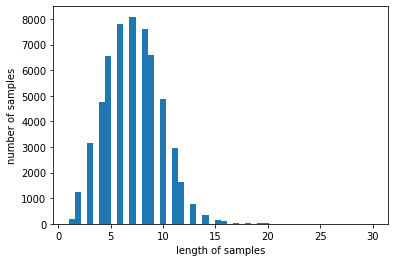

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 100.0


In [ ]:
# 60 이하인 걸로 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
len(X_train), len(X_test)

(56937, 57)

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


SystemError: ignored

In [ ]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional,BatchNormalization, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
embedding_dim = 128
model = Sequential([
    Embedding(vocab_size, embedding_dim), # lstm units [32,64,128,256]
    Bidirectional(GRU(32,activation = 'softsign',dropout = 0.5,return_sequences=True,go_backwards = True)), # Bidirectional LSTM을 사용 #return_sequences=True
    Bidirectional(GRU(32,activation = 'softsign',dropout = 0.5,return_sequences=True)),
    BatchNormalization(),
    Dense(32, activation='relu', kernel_regularizer='l2'),

    Bidirectional(GRU(32,activation = 'softsign',dropout = 0.5,return_sequences=True)),
    Bidirectional(GRU(32,activation = 'softsign',dropout = 0.5,return_sequences=True)),
    BatchNormalization(),

    Bidirectional(GRU(32,activation = 'softsign',dropout = 0.5,return_sequences=True)),
    Bidirectional(GRU(32,activation = 'softsign',dropout = 0.5,return_sequences=True)),
    Dense(32, activation='relu', kernel_regularizer='l2'),

    Bidirectional(GRU(32,activation = 'softsign',dropout = 0.5,return_sequences=True)),
    Bidirectional(GRU(32,activation = 'softsign',dropout = 0.5, go_backwards = True)),
    Dense(5, activation='softmax')
])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
mc = ModelCheckpoint('/content/drive/MyDrive/colab/LSTM tuning/GRU_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc']) # optimizer ['adam', 'rmsprop', 'AdaGrad']
history = model.fit(X_train, y_train, epochs=20, callbacks=[es,mc], batch_size=64, validation_split=0.2)

Epoch 1/20
712/712 [==============================] - ETA: 0s - loss: 1.4949 - acc: 0.3739
Epoch 1: val_acc improved from -inf to 0.49025, saving model to /content/drive/MyDrive/colab/LSTM tuning/GRU_best_model.h5
712/712 [==============================] - 336s 431ms/step - loss: 1.4949 - acc: 0.3739 - val_loss: 1.2162 - val_acc: 0.4903
Epoch 2/20
712/712 [==============================] - ETA: 0s - loss: 1.1679 - acc: 0.5015
Epoch 2: val_acc improved from 0.49025 to 0.52766, saving model to /content/drive/MyDrive/colab/LSTM tuning/GRU_best_model.h5
712/712 [==============================] - 299s 420ms/step - loss: 1.1679 - acc: 0.5015 - val_loss: 1.1366 - val_acc: 0.5277
Epoch 3/20
712/712 [==============================] - ETA: 0s - loss: 1.0633 - acc: 0.5871
Epoch 3: val_acc improved from 0.52766 to 0.60414, saving model to /content/drive/MyDrive/colab/LSTM tuning/GRU_best_model.h5
712/712 [==============================] - 300s 421ms/step - loss: 1.0633 - acc: 0.5871 - val_loss: 1.

In [ ]:
from tensorflow import keras
model_load = keras.models.load_model('/content/drive/MyDrive/DL_project/LSTM tuning/best_model.h5')